# Working environnment

In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
from matplotlib.gridspec import GridSpec

# Feature engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# Importing data
df_pred_txt = pd.read_pickle('df_pred_text.pkl')
df_pred_img = pd.read_pickle('CNN_prediction.pkl')

# Creating a dataset containing all probabilities and results
data = df_pred_txt.join(df_pred_img)

In [76]:
# Function for plotting scores
def plot_report(y_true, y_pred, class_names, title = ""):
    fig = plt.figure(figsize = (15,5))
    fig.suptitle(title, fontweight = 'heavy')
    gs = fig.add_gridspec(1,2, width_ratios = [1,2])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[0])
    
    # Plot classification report
    report = classification_report(y_true, y_pred, output_dict = True, target_names = class_names)
    df_report = pd.DataFrame(report).iloc[:2,:7]
    acc = round(100*report['accuracy'],1)
    
    df_report.T.plot(kind = 'bar', rot = 30, ax = ax1)
    ax1.set_title('Classification report (accuracy = {}%)'.format(acc), fontweight = 'demibold', fontsize = 10)
    ax1.set_xticklabels(class_names, rotation = 30, horizontalalignment = 'right')
    ax1.grid(True)
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.subplot(ax2)
    sns.heatmap(conf_matrix, cmap = 'RdYlGn', annot = True, square = True, 
                cbar = False, xticklabels = class_names, yticklabels = class_names)
    ax2.set_title('Confusion matrix', fontweight = 'demibold', fontsize = 10)
    ax2.set_xticklabels(class_names, rotation = 30, horizontalalignment = 'right')
    plt.show()

# Predictions based on both models

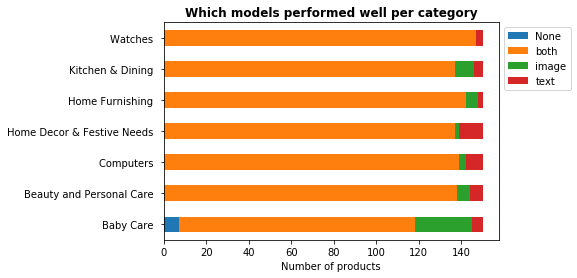

In [68]:
# Share of categories correctly predicted by both models
le = LabelEncoder()
data['label'] = le.fit_transform(data['category'])
class_names = le.inverse_transform(range(7))

data['well_predicted'] = "None"
data['well_predicted'] = data['well_predicted'].mask((data['txt_prediction'] == data['label']) & (data['img_prediction'] == data['label']), other = 'both')
data['well_predicted'] = data['well_predicted'].mask((data['txt_prediction'] == data['label']) & (data['img_prediction'] != data['label']), other = 'text')
data['well_predicted'] = data['well_predicted'].mask((data['txt_prediction'] != data['label']) & (data['img_prediction'] == data['label']), other = 'image')

# Performance per category
df_gr_ = data.groupby(['category', 'well_predicted'], as_index = False).agg({'image' : 'count'})
df_gr_.pivot(index = 'category', columns = 'well_predicted', values = 'image').plot(kind = 'barh', stacked = True)
plt.title("Which models performed well per category", fontweight = 'bold')
plt.xlabel('Number of products')
plt.ylabel(None)
plt.legend(bbox_to_anchor = (1,1,0,0))
plt.show()

In [59]:
# Data preprocessing
features_columns = [x for x in data.columns if "p(C" in x]
X_ = data[features_columns]
y_ = data['label']

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.3)

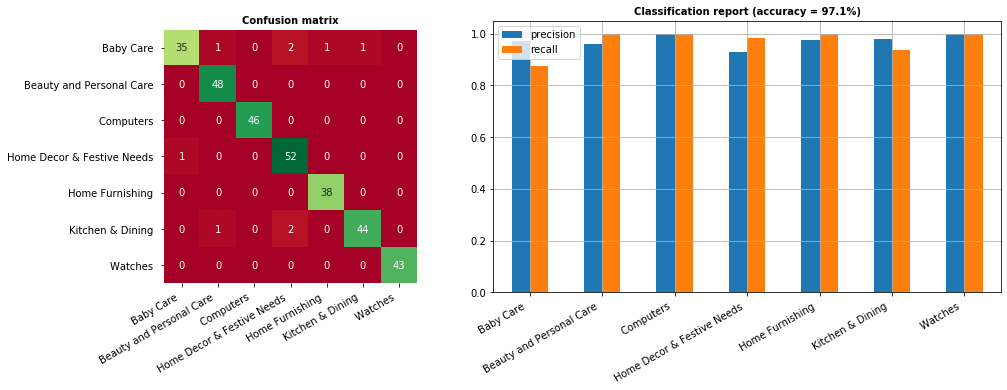

In [77]:
# Perceptron model
percep = Perceptron()
percep.fit(X_train, y_train)
y_percep = percep.predict(X_test)

plot_report(y_test, y_percep, class_names = class_names)

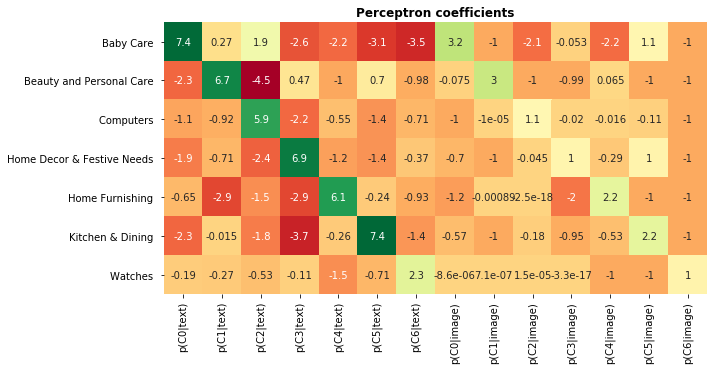

In [80]:
df_percep = pd.DataFrame(percep.coef_, index = class_names, columns = features_columns)
plt.figure(figsize = (25,5))
sns.heatmap(df_percep, cmap = 'RdYlGn', annot = True, square = True, cbar = False)
plt.title("Perceptron coefficients", fontweight = 'bold')
plt.show()